# Carvana Image Masking Challenge 

The goal of this challenge is to create a machine learning model capable of masking images. So that the car will be separated from the background.

[DATA](https://www.kaggle.com/c/carvana-image-masking-challenge/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from torchvision import transforms, datasets

# Exploring Metadata
Considering how large this dataset is. It would be beneficial to know what types and years the cars that populate this dataset are.

In [2]:
df = pd.read_csv('data/metadata.csv')
df = df.dropna()
df.shape

(6485, 6)

# Number of Cars by Year

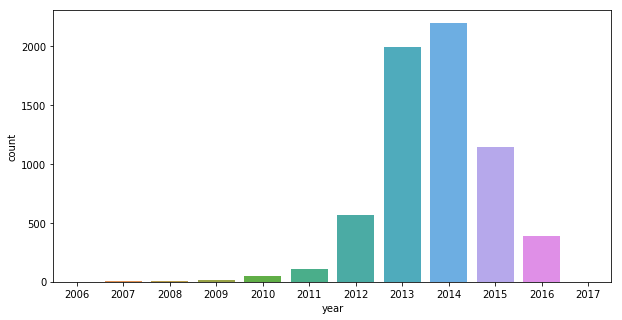

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df['year'].astype('int'))
plt.show()

# Number of Cars by Make

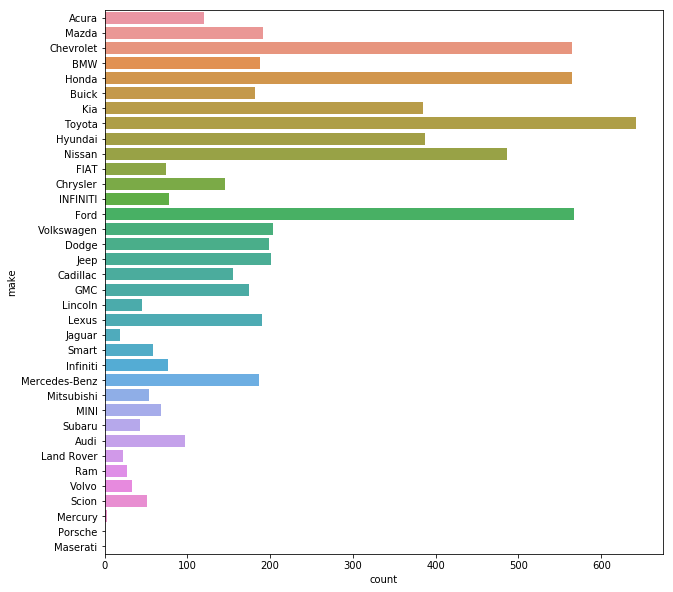

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y=df['make'], orient='h')
plt.show()

# Previewing Train Images

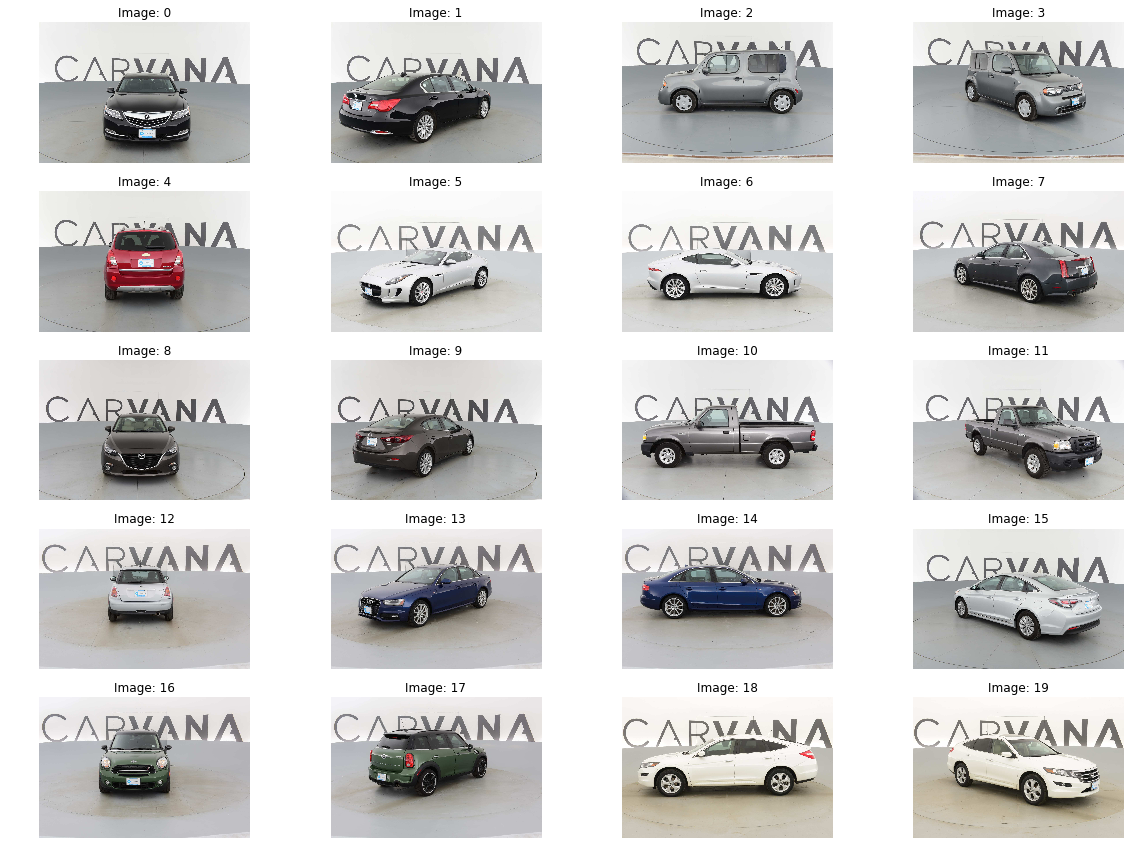

In [5]:
def get_images(folder, img_type, image_iter=None):
    fig = plt.figure(figsize=(20, 15))
    
    images = glob.glob(folder + '/*.' + img_type)
    
    if image_iter is not None:
        images = images[0::image_iter] # Selecting every 10th image to get a better variety

    counter = 0
    for image in images:
        if counter >= 20:
            break
        plt.subplot(5, 4, counter + 1)
        plt.axis('off')
        preview = Image.open(image)
        preview = np.array(preview)
        plt.imshow(preview.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(f'Image: {counter}')
        counter += 1

    plt.show()

folder = './data/train'
img_type = 'jpg'
image_iter = 10

get_images(folder, img_type, image_iter)

# Previewing Test Images

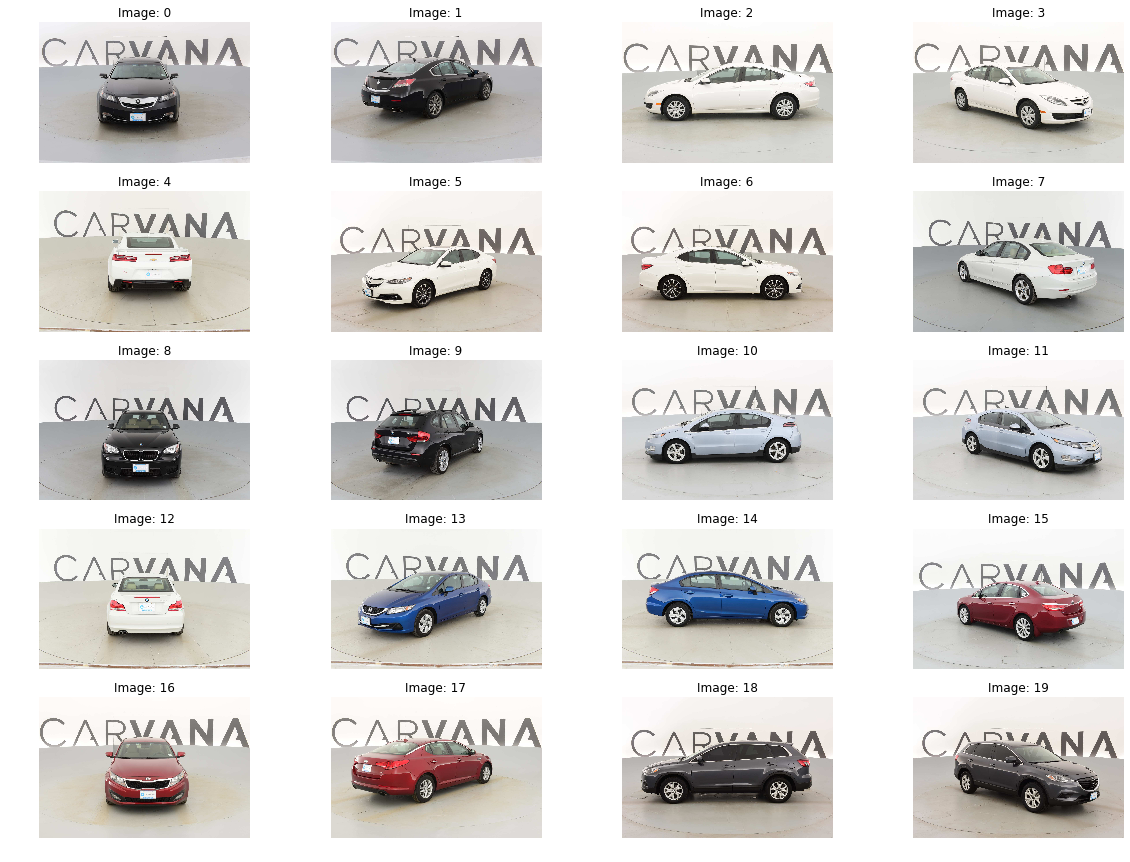

In [6]:
folder = './data/test'
img_type = 'jpg'
image_iter = 10

get_images(folder, img_type, image_iter)

# Previewing Masks 

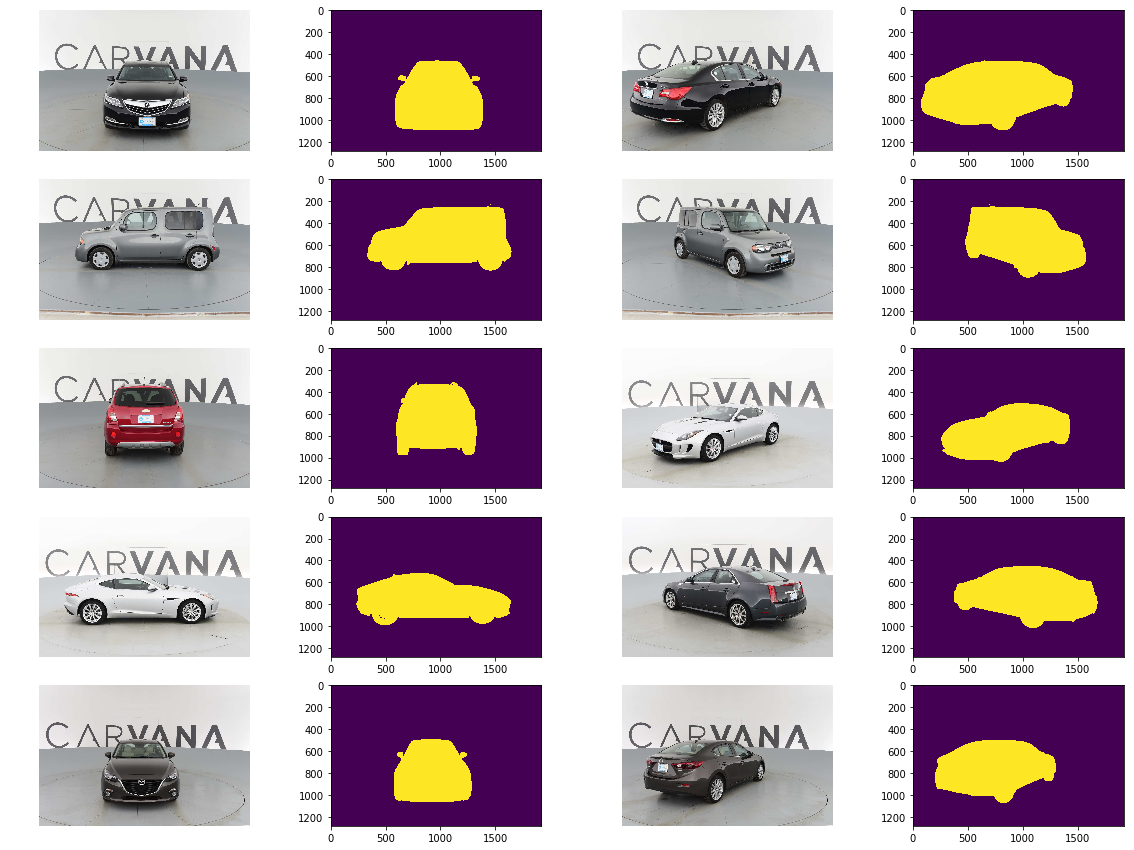

In [7]:
fig = plt.figure(figsize=(20, 15))

train = glob.glob('./data/train/*.jpg')
masks = glob.glob('./data/train_masks/*.gif' )
image_iter = 10

train = train[0::image_iter] # Selecting every 10th image to get a better variety
masks = masks[0::image_iter]

counter = 0
for image, mask in zip(train, masks):
    if counter >= 20:
        break
    plt.subplot(5, 4, counter + 1)
    plt.axis('off')
    train = Image.open(image)
    train = np.array(train)
    mask = Image.open(mask)
    mask = np.array(mask)
    plt.imshow(train.squeeze(), interpolation='nearest')
    counter +=1
    
    plt.subplot(5, 4, counter + 1)
    plt.imshow(mask.squeeze(), interpolation='nearest')
    counter += 1

plt.show()

# Collecting Data for Normalization

In [8]:
tensor_transform = transforms.Compose([
        transforms.ToTensor()
])

img_data = datasets.ImageFolder(root='../final/data/train', transform=tensor_transform)

img_tensors = torch.utils.data.DataLoader(dataset=img_data, batch_size=1, num_workers=4)

img_mean = []
img_std = []

for i, data in enumerate(img_tensors, 0):
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    img_mean.append(batch_mean)
    img_std.append(batch_std)

img_mean = np.array(img_mean).mean(axis=0)
img_std = np.array(img_std).mean(axis=0)

print(f'Mean\n{img_mean}\n')
print(f'Standard Deviations\n{img_std}')

Mean
[0.65860915 0.6646182  0.6600519 ]

Standard Deviations
[0.25401205 0.2530862  0.24853055]


# Data Loading

In [9]:
batch_size = 1

class CarvanaDataset(Dataset):
    def __init__(self, operation='train', transform=None):
        self.operation = operation
        self.transform = transform
        self.target_transform = transforms.Compose([
            transforms.Resize([360,360]),
            transforms.ToTensor(),
        ])
        
        if self.operation == 'train':
            self.imgs = glob.glob('../final/data/train/*.jpg')
            self.labels = glob.glob('../final/data/train_masks/*.gif')
            
        elif self.operation == 'test':
            self.imgs = glob.glob('../final/data/test/*.jpg')
            self.labels = glob.glob('../final/data/train_masks/*.gif')
            
    def __getitem__(self, index):
        # Load images and labels
        img = Image.open(self.imgs[index]).convert('RGB')
        target = Image.open(self.labels[index])
        
        # Apply transformations
        if self.transform is not None:
            img = self.transform(img)
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
data_transform = transforms.Compose([
        transforms.Resize([360,360]),
        transforms.ToTensor(),
        transforms.Normalize(img_mean, img_std)
    ])

train_dataset = CarvanaDataset(transform=data_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# PyTorch Fully Convolutional Neural Network.

This architecture has been proven to be a strong contender for image segmentation tasks. By not including a fully connected linear layer the convolutional layers can focus on features within the images. The downside to fully convolutional neural networks is that they're computationally expensive. However by downsampling and then upsampling the overall computational cost can be reduced. The following neural net architecture below closely follows the research proposed in the U-Net paper.

In [10]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode, align):
        super(Interpolate, self).__init__()
        self.interp = F.interpolate
        self.scale = scale_factor
        self.mode = mode
        self.align = align
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale, mode=self.mode, align_corners=self.align)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.down_layer1 = nn.Sequential(
             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        self.down_layer2 = nn.Sequential(
             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        self.down_layer3 = nn.Sequential(
             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        self.down_layer4 = nn.Sequential(
             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.up_sample_layer = nn.Sequential(
             Interpolate(scale_factor=2, mode='bilinear', align=True),
        )    
        
        self.up_layer1 = nn.Sequential(
             nn.Conv2d(768, 256, kernel_size=3, stride=1, padding=1),
             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        self.up_layer2 = nn.Sequential(
             nn.Conv2d(384, 128, kernel_size=3, stride=1, padding=1),
             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        self.up_layer3 = nn.Sequential(
             nn.Conv2d(192, 64, kernel_size=3, stride=1, padding=1),
             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
             nn.ReLU(inplace=True))
        
        self.out_layer = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        
        
    def forward(self, x):
        conv1 = self.down_layer1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.down_layer2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down_layer3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.down_layer4(x)
        
        x = self.up_sample_layer(conv4)
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up_layer1(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.up_layer2(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.up_layer3(x)
        x = self.out_layer(x)
        
        return x

# Utilities
The following functions are needed to aid the convolutional neural network.

- The Dice loss is not included in PyTorch, below are two functions implementing it.

- The Average Meter class is for keeping track of training statistics.

- Save model is a helper function to keep variations of the model.

In [11]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
    
def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss
    
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def save_model(model, epoch):
        out_dir = './data/models/dice_epoch_' + str(epoch)
        torch.save(model.state_dict(), out_dir)

# U-Net PyTorch Model
The choice of the U-Net architurecture was problem specific. 

In [12]:
model = ConvNet()

optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


if torch.cuda.is_available():
    model = model.cuda()

def train(train_loader, model, epoch, num_epochs):
    model.train()
    losses = AverageMeter()

    # set a progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        # Convert torch tensor to Variable
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # compute output
        optimizer.zero_grad()
        outputs = model(images)

        # measure loss
        loss = calc_loss(outputs, labels)
        # loss = F.binary_cross_entropy_with_logits(outputs, labels)
        losses.update(loss.data, images.size(0))

        # compute gradient and do optimizer step
        loss.backward()
        optimizer.step()

        pbar.set_description('[TRAIN] - EPOCH %d/ %d - BATCH LOSS: %.4f'
                             % (epoch + 1, num_epochs, losses.val))
        
        
    # return avg loss over the epoch
    return losses.avg

In [13]:
n_epochs = 30

for epoch in range(n_epochs):
    curr_loss = train(train_loader, model, epoch, n_epochs)
    save_model(model, epoch)

print(f'Ending Loss - {curr_loss}')

[TRAIN] - EPOCH 2/ 30 - BATCH LOSS: 1004.3132:   1%|▎                                | 47/5088 [00:11<20:01,  4.20it/s]

KeyboardInterrupt: 

[[[[0. 1. 1. ... 0. 0. 0.]
   [0. 1. 1. ... 0. 0. 0.]
   [0. 1. 1. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]]]]


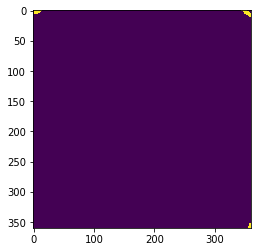

In [15]:
# Loading Previous Model
checkpoint = torch.load('G:\\projects\\thinkful\\final\\data\\models\\dice_epoch_0')
model.load_state_dict(checkpoint)
model.eval()   # Set model to the evaluation mode

# Create another simulation dataset for test
test_dataset = CarvanaDataset(operation='test', transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    
inputs, labels = next(iter(test_loader))
inputs = inputs.cuda()
labels = labels.cuda()

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred)


plt.imshow(pred.squeeze()>0)

plt.show()